In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Define the simplified AlexNet model
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(6272, 1024),  # Adjusted to the correct size
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the model
model = SimplifiedAlexNet().to(device)

# Calculate the number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of parameters:", params)

Number of parameters: 7012554


In [4]:
# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Training settings
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")

# Calculate the average training and validation accuracy across all epochs
average_training_accuracy = sum(epoch_training_accuracies) / len(epoch_training_accuracies)
average_validation_accuracy = sum(epoch_validation_accuracy) / len(epoch_validation_accuracy)

# Find the best (maximum) validation accuracy achieved during training
best_validation_accuracy = max(epoch_validation_accuracy)

print(f"Average Training Accuracy: {average_training_accuracy}%")
print(f"Average Validation Accuracy: {average_validation_accuracy}%")
print(f"Best Validation Accuracy: {best_validation_accuracy}%")

Epoch 1, Training Loss: 1.3099792466291686, Validation Loss: 1.0529291570186614, Accuracy: 62.81%
Epoch 2, Training Loss: 0.8741826860953474, Validation Loss: 0.863212114572525, Accuracy: 70.66%
Epoch 3, Training Loss: 0.6720932433596047, Validation Loss: 0.7701565206050873, Accuracy: 73.24%
Epoch 4, Training Loss: 0.5276170116670601, Validation Loss: 0.7339095413684845, Accuracy: 75.35%
Epoch 5, Training Loss: 0.393748920753865, Validation Loss: 0.8341335952281952, Accuracy: 74.48%
Epoch 6, Training Loss: 0.28739795983409333, Validation Loss: 0.9261339187622071, Accuracy: 75.18%
Epoch 7, Training Loss: 0.2009092610153129, Validation Loss: 1.0614255964756012, Accuracy: 74.46%
Epoch 8, Training Loss: 0.15750430225539963, Validation Loss: 1.1679632306098937, Accuracy: 74.15%
Epoch 9, Training Loss: 0.12419728878194757, Validation Loss: 1.3164332032203674, Accuracy: 74.25%
Epoch 10, Training Loss: 0.10843940630562299, Validation Loss: 1.4382999420166016, Accuracy: 73.44%
Epoch 11, Trainin

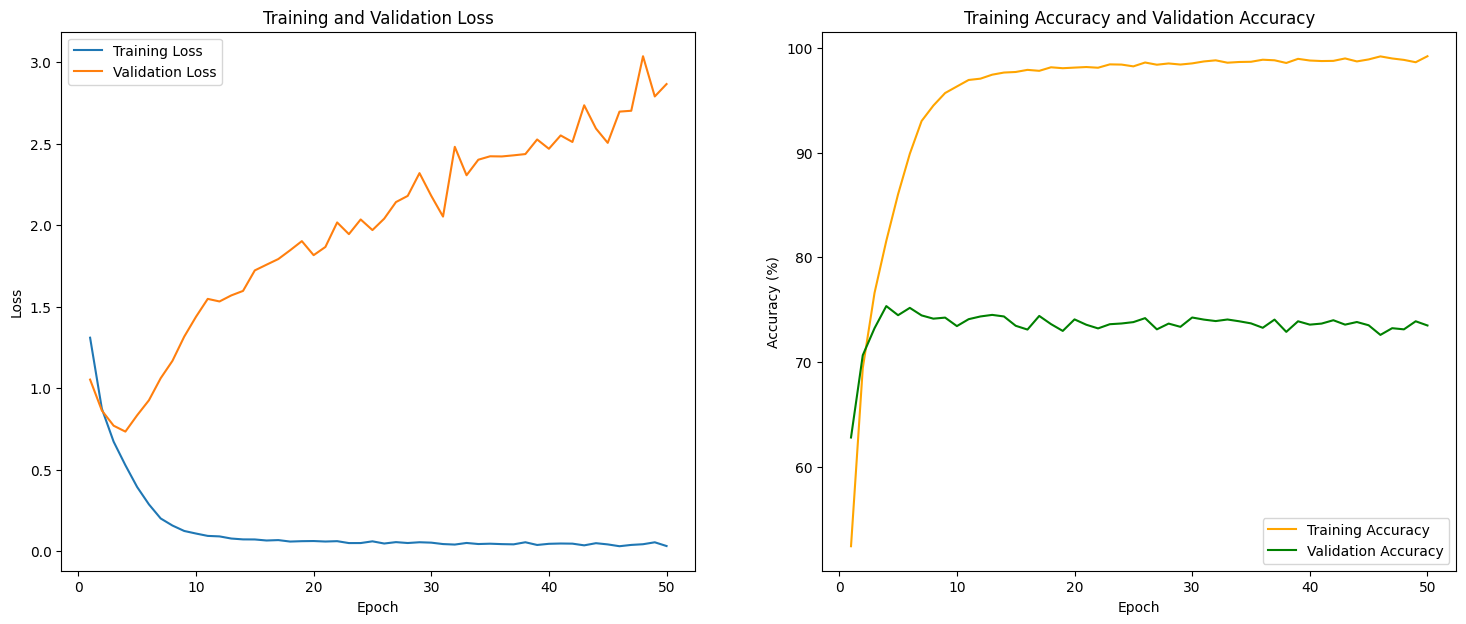

In [6]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()

In [7]:
class AlexNetWithDropout(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetWithDropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),  # Dropout after max pooling
            nn.Conv2d(48, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.5),  # Dropout after max pooling
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout before fully connected layers
            nn.Linear(6272, 1024),  # Corrected to match the actual flattened size
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Additional dropout layer
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
# Initialize the model
model1 = AlexNetWithDropout().to(device)

# Calculate the number of parameters
model1_parameters = filter(lambda p: p.requires_grad, model1.parameters())
params = sum([np.prod(p.size()) for p in model1_parameters])
print("Number of parameters:", params)

Number of parameters: 7012554


In [8]:
# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    model1.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    model1.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")
# Calculate the average training and validation accuracy across all epochs
average_training_accuracy = sum(epoch_training_accuracies) / len(epoch_training_accuracies)
average_validation_accuracy = sum(epoch_validation_accuracy) / len(epoch_validation_accuracy)

# Find the best (maximum) validation accuracy achieved during training
best_validation_accuracy = max(epoch_validation_accuracy)

print(f"Average Training Accuracy: {average_training_accuracy}%")
print(f"Average Validation Accuracy: {average_validation_accuracy}%")
print(f"Best Validation Accuracy: {best_validation_accuracy}%")

Epoch 1, Training Loss: 1.5856430620488609, Validation Loss: 1.3349682807922363, Accuracy: 54.51%
Epoch 2, Training Loss: 1.320861187508649, Validation Loss: 1.159748136997223, Accuracy: 60.99%
Epoch 3, Training Loss: 1.2070085682222604, Validation Loss: 1.0849387764930725, Accuracy: 65.12%
Epoch 4, Training Loss: 1.1313268307529751, Validation Loss: 1.0049966394901275, Accuracy: 67.86%
Epoch 5, Training Loss: 1.081347206135845, Validation Loss: 0.9807217180728912, Accuracy: 68.17%
Epoch 6, Training Loss: 1.0484815558509144, Validation Loss: 0.9359560072422027, Accuracy: 68.52%
Epoch 7, Training Loss: 1.0210445439419173, Validation Loss: 0.8959978878498077, Accuracy: 71.03%
Epoch 8, Training Loss: 0.994171838092682, Validation Loss: 0.8779558956623077, Accuracy: 72.05%
Epoch 9, Training Loss: 0.9746293533793495, Validation Loss: 0.8578424036502839, Accuracy: 72.69%
Epoch 10, Training Loss: 0.9584105267853993, Validation Loss: 0.8582115769386292, Accuracy: 72.63%
Epoch 11, Training Loss

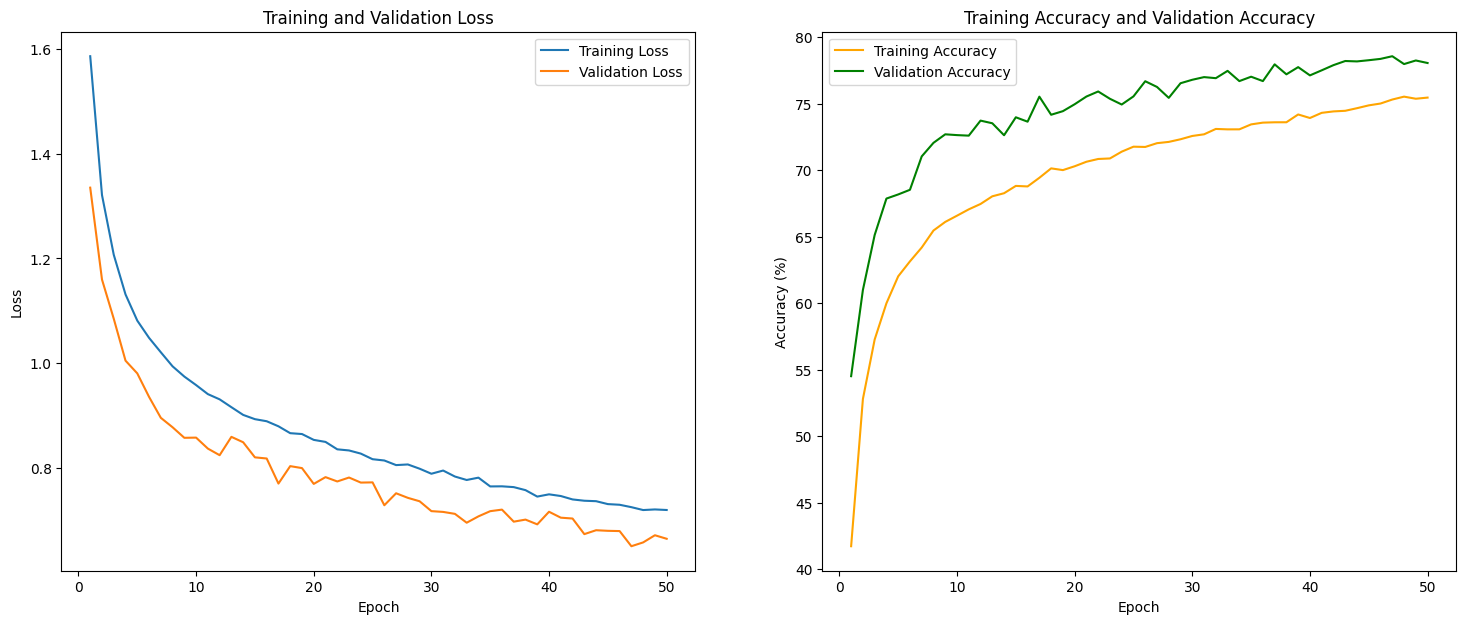

In [10]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the ResNet-18 model
resnet18 = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
# Count the number of trainable parameters
num_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print('Number of parameters in ResNet-18:', num_params)

Number of parameters in ResNet-18: 11181642


In [12]:
""# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    resnet18.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    resnet18.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")
    # Calculate the average training and validation accuracy across all epochs
average_training_accuracy = sum(epoch_training_accuracies) / len(epoch_training_accuracies)
average_validation_accuracy = sum(epoch_validation_accuracy) / len(epoch_validation_accuracy)

# Find the best (maximum) validation accuracy achieved during training
best_validation_accuracy = max(epoch_validation_accuracy)

print(f"Average Training Accuracy: {average_training_accuracy}%")
print(f"Average Validation Accuracy: {average_validation_accuracy}%")
print(f"Best Validation Accuracy: {best_validation_accuracy}%")

Epoch 1, Training Loss: 1.3912943457551015, Validation Loss: 1.3965671181678772, Accuracy: 52.57%
Epoch 2, Training Loss: 0.9963561091429133, Validation Loss: 0.9938779652118683, Accuracy: 64.85%
Epoch 3, Training Loss: 0.8158777585572294, Validation Loss: 0.9530042052268982, Accuracy: 67.84%
Epoch 4, Training Loss: 0.6989596544019402, Validation Loss: 0.79737628698349, Accuracy: 72.43%
Epoch 5, Training Loss: 0.6028406209195666, Validation Loss: 0.7612549126148224, Accuracy: 73.83%
Epoch 6, Training Loss: 0.513379939014802, Validation Loss: 0.744178730249405, Accuracy: 75.0%
Epoch 7, Training Loss: 0.43079067985801134, Validation Loss: 0.7804040491580964, Accuracy: 75.31%
Epoch 8, Training Loss: 0.3590321387628765, Validation Loss: 0.7509734749794006, Accuracy: 77.06%
Epoch 9, Training Loss: 0.29915133931333454, Validation Loss: 0.8044800937175751, Accuracy: 75.22%
Epoch 10, Training Loss: 0.24170316652397214, Validation Loss: 0.7956518769264221, Accuracy: 77.09%
Epoch 11, Training Lo

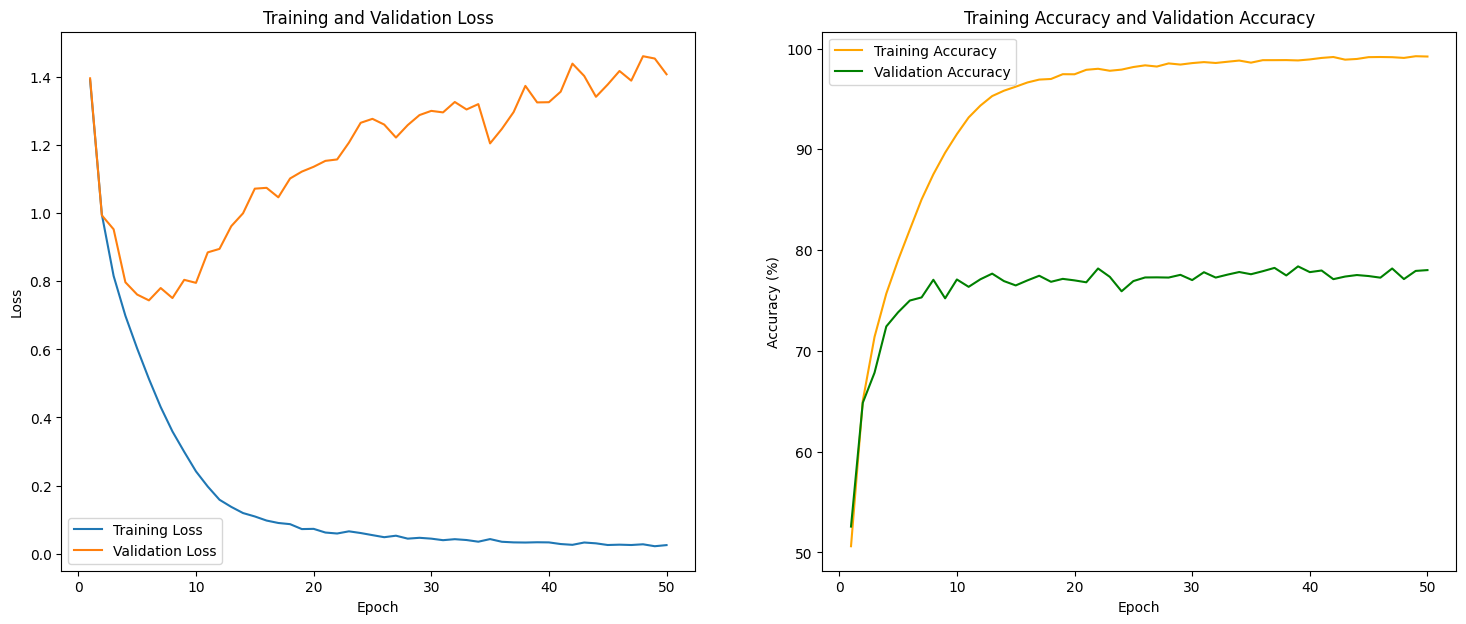

In [14]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()

In [21]:
class BasicBlockWithDropout(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout2 = nn.Dropout2d(dropout_rate)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.dropout2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.25):
        super(ResNet18, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate=dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model2 = ResNet18(BasicBlockWithDropout, [2, 2, 2, 2], num_classes=10, dropout_rate=0.5).to(device) 
    
# Count the number of trainable parameters
num_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print('Number of parameters in ResNet-18 with dropout:', num_params)

Number of parameters in ResNet-18 with dropout: 11173962


In [17]:
""# CIFAR-10 data loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
epochs = 50
epoch_training_losses = []
epoch_training_accuracies = []  # To store training accuracy
epoch_validation_losses = []
epoch_validation_accuracy = []
# Training loop
for epoch in range(epochs):
    model2.train()
    running_loss = 0.0
    correct = 0  # To track number of correct predictions
    total = 0  # To track total number of predictions
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate and store average training loss and accuracy for this epoch
    avg_training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    epoch_training_losses.append(avg_training_loss)
    epoch_training_accuracies.append(training_accuracy)
        

    # Validation
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate and store average validation loss and accuracy for this epoch
    avg_validation_loss = val_loss / len(test_loader)
    validation_accuracy = 100 * correct / total
    epoch_validation_losses.append(avg_validation_loss)
    epoch_validation_accuracy.append(validation_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_training_loss}, Validation Loss: {avg_validation_loss}, Accuracy: {validation_accuracy}%")
    # Calculate the average training and validation accuracy across all epochs
average_training_accuracy = sum(epoch_training_accuracies) / len(epoch_training_accuracies)
average_validation_accuracy = sum(epoch_validation_accuracy) / len(epoch_validation_accuracy)

# Find the best (maximum) validation accuracy achieved during training
best_validation_accuracy = max(epoch_validation_accuracy)

print(f"Average Training Accuracy: {average_training_accuracy}%")
print(f"Average Validation Accuracy: {average_validation_accuracy}%")
print(f"Best Validation Accuracy: {best_validation_accuracy}%")

In [ ]:
plt.figure(figsize=(18, 7))

# Plot training and validation loss
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), epoch_training_losses, label='Training Loss')
plt.plot(range(1, epochs+1), epoch_validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), epoch_training_accuracies, label='Training Accuracy', color='orange')
plt.plot(range(1, epochs+1), epoch_validation_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()


plt.show()